<a href="https://colab.research.google.com/github/Alex-5551/Agric-Trust/blob/main/Agriconnect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



##AgriConnect Summit Hackathon - Bridging the Generational Divide



Import relevant libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from scipy.stats.mstats import trimmed_var
from sklearn.cluster import KMeans, AffinityPropagation, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder

In [2]:
raw_data = pd.read_csv("/content/drive/MyDrive/A2F_2023_Revised.csv")
raw_data.head()

<ipython-input-2-0410ec5258b2>:1: DtypeWarning: Columns (42,98,134,136,158,186,208,216,220,533,682,683,684,686,687,688,690,692,693,694,695,696,697,743,771,832,849,858,871,886,908,921,929,955,957,962,963,974,984,989,990,1001,1003,1012,1013,1015,1016,1018,1029,1032,1040,1041,1043,1044,1046,1069,1070,1085,1088,1099,1113,1130,1140,1146,1180,1210,1213,1215,1220,1239,1254,1268,1288,1291,1307,1318,1333,1353,1364,1376,1398,1450,1538) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_data = pd.read_csv("/content/drive/MyDrive/A2F_2023_Revised.csv")


,statecode,state_code,e6,state,agegroup,respondent_serial,Weightingvariable,final_hh_wgt,region,state_name,...,finneeds_transferofvalue,target_groups,savings_group,cooperative,village_comm_association,savings_thrift,microfinance,money_lender,finhealth_indicator_final,finlit_cap_final
0,1.0,31.0,2.0,ABIA,2.0,3697287.0,686.992065,749.888855,2.0,ABIA,...,1.0,2.0,0.0,0.0,0.0,0.0,NaN,NaN,1.0,1.0
1,1.0,31.0,2.0,ABIA,2.0,3546312.0,1292.105957,1028.419067,2.0,ABIA,...,1.0,2.0,0.0,0.0,0.0,0.0,NaN,NaN,1.0,0.0
2,1.0,31.0,1.0,ABIA,2.0,3737095.0,274.308411,492.784119,2.0,ABIA,...,1.0,5.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0
3,1.0,31.0,1.0,ABIA,2.0,3545118.0,1194.719360,1028.419067,2.0,ABIA,...,1.0,5.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0
4,1.0,31.0,1.0,ABIA,2.0,3705829.0,4107.366211,1906.860229,2.0,ABIA,...,1.0,4.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0


In [ ]:
raw_data.shape

(28392, 1613)

## Data cleaning and Visualization

In [ ]:
## A function to wrangle data
def wrangle(filepath):

    #read data into pandas dataframe
    raw_df = pd.read_csv(filepath)

    #subset to youths. Age: 18 to 25
    df = raw_df.query('(e7>=18) and (e7<=25)')

    #select relevant columns that impacts an individuals creditworthiness
    cols = ["state", "sector", "finhealth_resilience", "finhealth_access","finhealth_indicator_final", "cc1_3", "cc1_6",
        "finlit_knowledge", "e7", "e8","ie1b","lc1_1", "lc1a", "gen3_1", "banked", "e13a_1", "e14_17", "e14_15", "e14_3","e6",
        "gen3_7", "insurance_strand", "e14_11", "credit_strand", "saving_strand","investments_physical_assets", "investments_capital_markets", "f5b"]
    drop_cols = [col for col in df.columns if col not in cols]
    df = df.drop(columns = drop_cols)

   #drop missing rows subsetting by secctor of work(e13a_1, individuals who work in Agriculture, forestry & fishing) and debt(lc1a, level of debt)
    df = df.dropna(subset=["lc1a", "e13a_1"])

    #rename columns
    df.rename(columns={
        "e7":"Age",
        "e14_3":"Voters_card",
        "e8": "Edu_level",
        "e14_11": "BVN",
        "e14_15": "Tax_invoice",
        "e14_17":"Tax_cert",
        "f5b": "invest_freq",
        "lc1_1": "Borrowed_in_past",
        "ie1b":"Avg_income",
        "gen3_1": "Own_agri_land",
        "gen3_7": "Own_agri_mech_tool",
        "e6": "Gender",
        "cc1_3": "Drought_damage",
        "cc1_6": "Pest_infestation",
        "e13a_1": "work_agri_forestry_fishing",
        "lc1a": "Debt"
    }, inplace = True)


    #Changing 99 to a number like 4 falsely implies an ordinal or quantitative relationship that does not exist,
    #misleading the model into learning patterns that are not real.
    credit_map = {
    1: "Bank",
    2: "Other Formal",
    3: "Informal Only",
    4: "Family and Friends",
    99: "Not Borrowing"
      }

    df['source_of_borrowing'] = df['credit_strand'].replace(credit_map)

    #mapping the insurance column
    insure_map = {99:"Not Insured", 1:"Insured"}
    df["insurance_strand"] = df["insurance_strand"].replace(insure_map)

    #mapping the saving_strand column
    save_map = {1: "Saving at bank",
                2: "Non_bank formal channel",
                3: "Informal mechanisms",
                4: "At home only",
                99: "Not Saving"}
    df["saving_strand"] = df["saving_strand"].replace(save_map)

    # replace unwanted reponse such as 18: "Refused", 19: "Don't Know", 20: "No income"
    df["Avg_income"] = df['Avg_income'].replace([18, 19,20], np.nan)
    imputer = SimpleImputer(missing_values = np.nan,strategy = "most_frequent")
    df["Avg_income"] = imputer.fit_transform(df[["Avg_income"]])

    #convert from float to integer. Example age can't be float
    for col in df.columns:
        if df[col].dtype == "float":
            df[col] = df[col].astype("int")
        else:
           df[col] = df[col].astype("object")

    df = df.drop(columns = "credit_strand")
    # reset index
    df  = df.reset_index(drop = True)

    return df

In [ ]:
df = wrangle("/content/drive/MyDrive/A2F_2023_Revised.csv")
df.head()

<ipython-input-7-28dd618d1089>:5: DtypeWarning: Columns (42,98,134,136,158,186,208,216,220,533,682,683,684,686,687,688,690,692,693,694,695,696,697,743,771,832,849,858,871,886,908,921,929,955,957,962,963,974,984,989,990,1001,1003,1012,1013,1015,1016,1018,1029,1032,1040,1041,1043,1044,1046,1069,1070,1085,1088,1099,1113,1130,1140,1146,1180,1210,1213,1215,1220,1239,1254,1268,1288,1291,1307,1318,1333,1353,1364,1376,1398,1450,1538) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_df = pd.read_csv(filepath)


,Gender,state,sector,Age,Edu_level,work_agri_forestry_fishing,Voters_card,BVN,Tax_invoice,Tax_cert,invest_freq,Borrowed_in_past,Debt,Drought_damage,Pest_infestation,Avg_income,Own_agri_land,Own_agri_mech_tool,banked,saving_strand,insurance_strand,investments_physical_assets,investments_capital_markets,finhealth_resilience,finhealth_access,finlit_knowledge,finhealth_indicator_final,source_of_borrowing
0,2,ABIA,1,25,4,0,1,2,2,2,2,2,2,2,2,2,2,3,2,Informal mechanisms,Not Insured,1,2,2,0,2,1,Family and Friends
1,1,ABIA,1,25,5,0,1,1,2,2,2,2,1,2,2,4,3,3,1,Saving at bank,Not Insured,2,2,0,2,2,1,Informal Only
2,2,ABIA,1,23,5,0,1,2,2,2,1,2,3,2,2,3,2,3,1,Saving at bank,Not Insured,1,2,1,0,2,1,Family and Friends
3,1,ABIA,1,23,5,0,1,1,2,2,3,2,2,2,2,2,3,3,1,Saving at bank,Not Insured,1,2,0,0,2,0,Family and Friends
4,1,ADAMAWA,2,25,5,1,1,1,2,2,2,1,1,2,2,2,2,3,2,Not Saving,Not Insured,1,2,0,0,0,1,Family and Friends


In [ ]:
df.shape

(1055, 28)

In [ ]:
print(df.shape)
df.info()

(1055, 28)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1055 entries, 0 to 1054
Data columns (total 28 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   Gender                       1055 non-null   int64 
 1   state                        1055 non-null   object
 2   sector                       1055 non-null   int64 
 3   Age                          1055 non-null   int64 
 4   Edu_level                    1055 non-null   int64 
 5   work_agri_forestry_fishing   1055 non-null   int64 
 6   Voters_card                  1055 non-null   int64 
 7   BVN                          1055 non-null   int64 
 8   Tax_invoice                  1055 non-null   int64 
 9   Tax_cert                     1055 non-null   int64 
 10  invest_freq                  1055 non-null   int64 
 11  Borrowed_in_past             1055 non-null   int64 
 12  Debt                         1055 non-null   int64 
 13  Drought_damage        

In [ ]:
print(df.shape)

df.describe()

(1055, 28)


,Gender,sector,Age,Edu_level,work_agri_forestry_fishing,Voters_card,BVN,Tax_invoice,Tax_cert,invest_freq,Borrowed_in_past,Debt,Drought_damage,Pest_infestation,Avg_income,Own_agri_land,Own_agri_mech_tool,banked,investments_physical_assets,investments_capital_markets,finhealth_resilience,finhealth_access,finlit_knowledge,finhealth_indicator_final
count,1055.000000,1055.000000,1055.000000,1055.000000,1055.000000,1055.000000,1055.000000,1055.000000,1055.000000,1055.000000,1055.000000,1055.000000,1055.000000,1055.000000,1055.000000,1055.000000,1055.000000,1055.000000,1055.000000,1055.000000,1055.000000,1055.000000,1055.000000,1055.000000
mean,1.574408,1.563033,22.437915,5.745972,0.458768,1.370616,1.575355,1.981043,1.981043,2.400948,1.150711,1.681517,1.929858,1.859716,2.144076,2.373460,2.949763,1.516588,1.433175,1.941232,0.527014,0.224645,0.968720,0.816114
std,0.494667,0.496246,2.402498,2.690894,0.498533,0.483199,0.494523,0.136439,0.136439,0.641245,0.357937,0.719074,0.255508,0.347447,1.798719,0.862929,0.295984,0.499962,0.495749,0.235301,0.760118,0.484836,0.898009,0.625461
min,1.000000,1.000000,18.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,20.000000,4.000000,0.000000,1.000000,1.000000,2.000000,2.000000,2.000000,1.000000,1.000000,2.000000,2.000000,1.000000,1.000000,3.000000,1.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000000,2.000000,23.000000,5.000000,0.000000,1.000000,2.000000,2.000000,2.000000,2.000000,1.000000,2.000000,2.000000,2.000000,2.000000,3.000000,3.000000,2.000000,1.000000,2.000000,0.000000,0.000000,1.000000,1.000000
75%,2.000000,2.000000,25.000000,6.000000,1.000000,2.000000,2.000000,2.000000,2.000000,3.000000,1.000000,2.000000,2.000000,2.000000,2.500000,3.000000,3.000000,2.000000,2.000000,2.000000,1.000000,0.000000,2.000000,1.000000
max,2.000000,2.000000,25.000000,11.000000,1.000000,2.000000,2.000000,2.000000,2.000000,3.000000,2.000000,4.000000,2.000000,2.000000,17.000000,3.000000,3.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000


In [ ]:
# encoding of Numeric variables for visualization
gender = df["Gender"].replace({1: "Male", 2: "Female"})


#own Agricultural land
own_agri=  df["Own_agri_land"].replace({1:"Own(in my name)",
                                        2:"Joint ownership",
                                        3:"Do no own"})


#Agricultural mechanical tools
mech_agri = df["Own_agri_mech_tool"].replace({
                                              1:"Own(in my name)",
                                              2:"Joint ownership",
                                              3:"Do no own"})

# Highest level of education
edu_level = df["Edu_level"].replace({1:"Pre-school",
    2: "Primary incomplete ",
    3:"Primary complete",
    4:"Secondary incomplete",
    5:"Secondary complete",
    6:"University/Polytechnic OND",
    7:"University/Polytechnic HND",
    8:"Post-university incomplete",
    9:"Post-university complete",
    10:"Non-formal education (e.g., Arabic/Quranic education)",
    11:"No education" })

#Income level
income_dict = {
    1:"Below N15,000 per month",
    2: "N15,001 - N35,000 per month",
    3:"N35001 - N55,000 per month",
    4: "N55,001 - N75,000 per month",
    5: "N75,001 - N95,000 per month",
    6: "N95,001 - N115,000 per month",
    7: "N115,001 - N135,000 per month",
    8: "N135,001 - N155,000 per month",
    9: "N155,001 - N175,000 per month",
    10: "N175,001 - N195,000 per month",
    11: "N195,001 - N215,000 per month ",
    12: "N215,001 - N235,000 per month",
    13: "N235,001 - N255,000 per month",
    14: "N255,001 - 275,000 per month",
    15: "N275,001 - 295,000 per month",
    16: "N295,001 - 315,000 per month",
    17: "Above N315,000 per month",
    18: "Refused",
    19: "Don't Know",
    20: "No income"
}

income_level = df["Avg_income"].replace(income_dict)

#Finlit_knowledge: Individuals who have awareness, understanding, and familiarity with financial concepts, products
fin_know = df["finlit_knowledge"].replace({0:"Low",
                                           1:"Moderate",
                                           2: "High"})
#fin_health indicator: An indicator that separates the population of a country into those who are financially healthy
#from those who are financially vulnerable
fin_indicator = df["finhealth_indicator_final"].replace({0:"Low(Financially Vulnerable)",
                                           1:"Moderate(Financially Coping)",
                                           2: "High(Financially Healthy)"})
#Experienced pest infestation
pest = df["Pest_infestation"].replace({1: "Yes", 2: "No"})
#Experienced Drought
drought = df["Drought_damage"].replace({1: "Yes", 2: "No"})

#Debt
debt = df["Debt"].replace({1: "Do not have any debt",
  2: "Have a manageable amount of debt",
  3: "Have a bit more debt than is manageable",
  4: "Have far more debt than is manageable"})

sector_df = df["sector"].replace({1: "urban", 2: "rural"})

In [ ]:
income_level.value_counts(normalize = True)

,proportion
Avg_income,
"Below N15,000 per month",0.442654
"N15,001 - N35,000 per month",0.307109
"N35001 - N55,000 per month",0.138389
"N55,001 - N75,000 per month",0.040758
"N95,001 - N115,000 per month",0.024645
"N75,001 - N95,000 per month",0.021801
"N135,001 - N155,000 per month",0.008531
"N195,001 - N215,000 per month",0.003791
"N115,001 - N135,000 per month",0.003791


In [ ]:
fig = plt.figure(figsize = (15,10))
state_count = df["state"].value_counts()

fig = px.bar(df, y = "state", color=gender, title = "Number of young respondents per state")
fig.update_layout(xaxis_title = "Number of respondents", yaxis_title = "State")
fig.show();

<Figure size 1500x1000 with 0 Axes>

In [ ]:
## Proportion of Youths in different sector
rural = sector_df.value_counts(normalize = True).iloc[0]
urban = sector_df.value_counts(normalize=True).iloc[1]
print(f"The proportion of youths in the rural sector is {rural: .1%}")
print(f"The proportion of youths in the urban sector is {urban: .1%}")

gender_count = gender.value_counts(normalize=True)
print(f"\nThe percentage of female youths is {gender_count.iloc[0]: .1%}")
print(f"The percentage of female youths is {gender_count.iloc[1]: .1%}")

indicator_count = fin_indicator.value_counts(normalize=True).sort_values()
print(f"\nThe percentage of financially venurable youths: {indicator_count.iloc[1]: .1%}")
print(f"The percentage of  financially coping youths: {indicator_count.iloc[2]: .1%}")
print(f"The percentage of  financially healthy youths: {indicator_count.iloc[0]: .1%}")

The proportion of youths in the rural sector is  56.3%
The proportion of youths in the urban sector is  43.7%

The percentage of female youths is  57.4%
The percentage of female youths is  42.6%

The percentage of financially venurable youths:  30.4%
The percentage of  financially coping youths:  57.5%
The percentage of  financially healthy youths:  12.0%


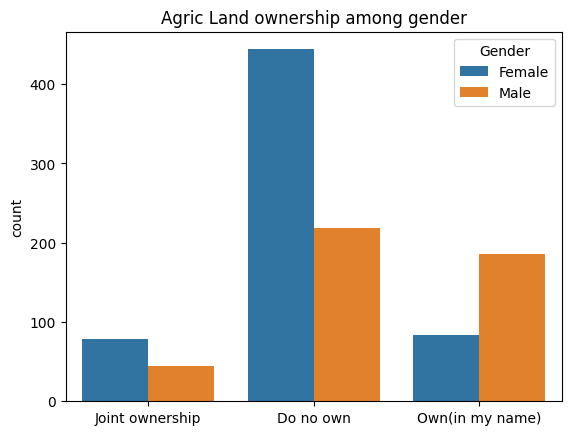

In [ ]:
sns.countplot(df, x =own_agri,hue = gender)
plt.title("Agric Land ownership among gender")
plt.xlabel("");

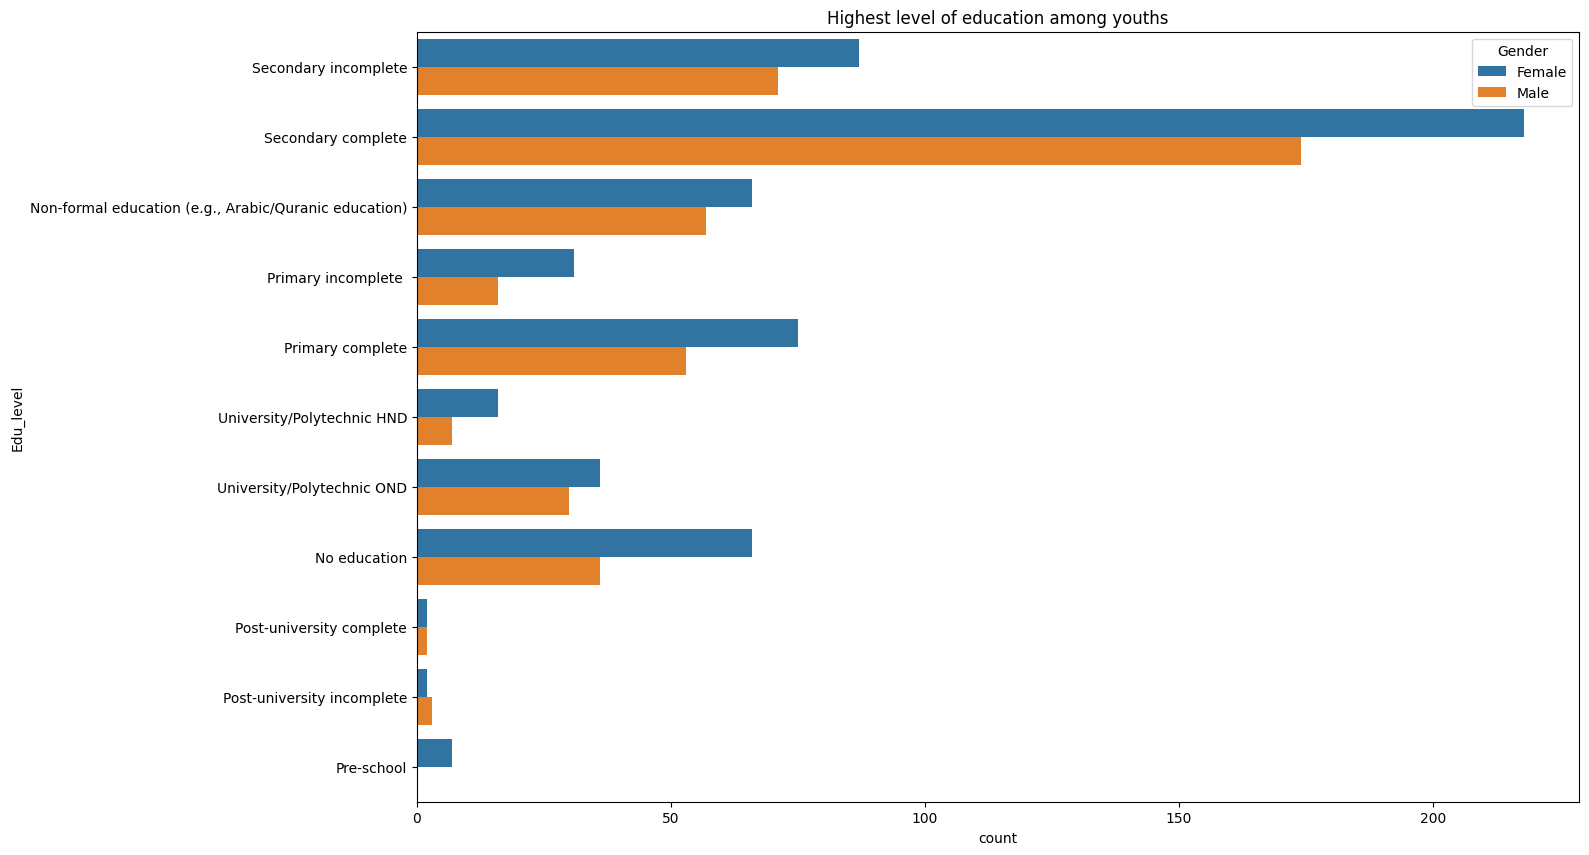

In [ ]:
fig = plt.figure(figsize = (15,10))
sns.countplot(y=edu_level, hue = gender)
plt.title("Highest level of education among youths");

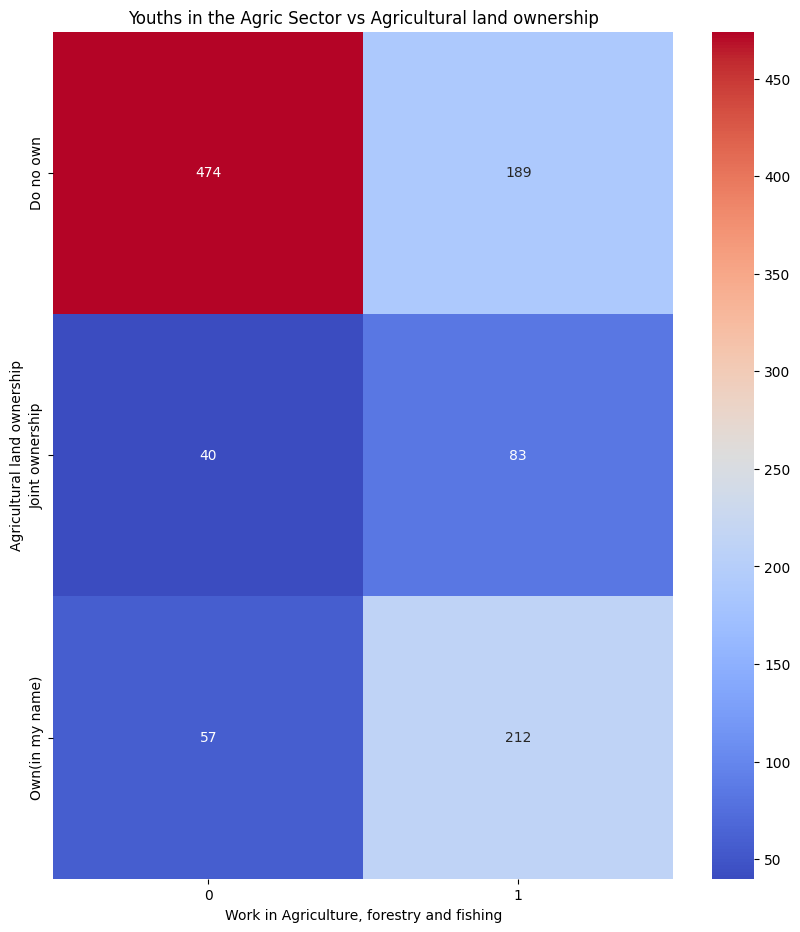

In [ ]:
ct = pd.crosstab(index = own_agri, columns = df["work_agri_forestry_fishing"])
fig = plt.figure(figsize = (10,11))

sns.heatmap(ct, annot =True, cmap = "coolwarm", fmt = "d")
plt.title("Youths in the Agric Sector vs Agricultural land ownership")
plt.ylabel("Agricultural land ownership")
plt.xlabel("Work in Agriculture, forestry and fishing");

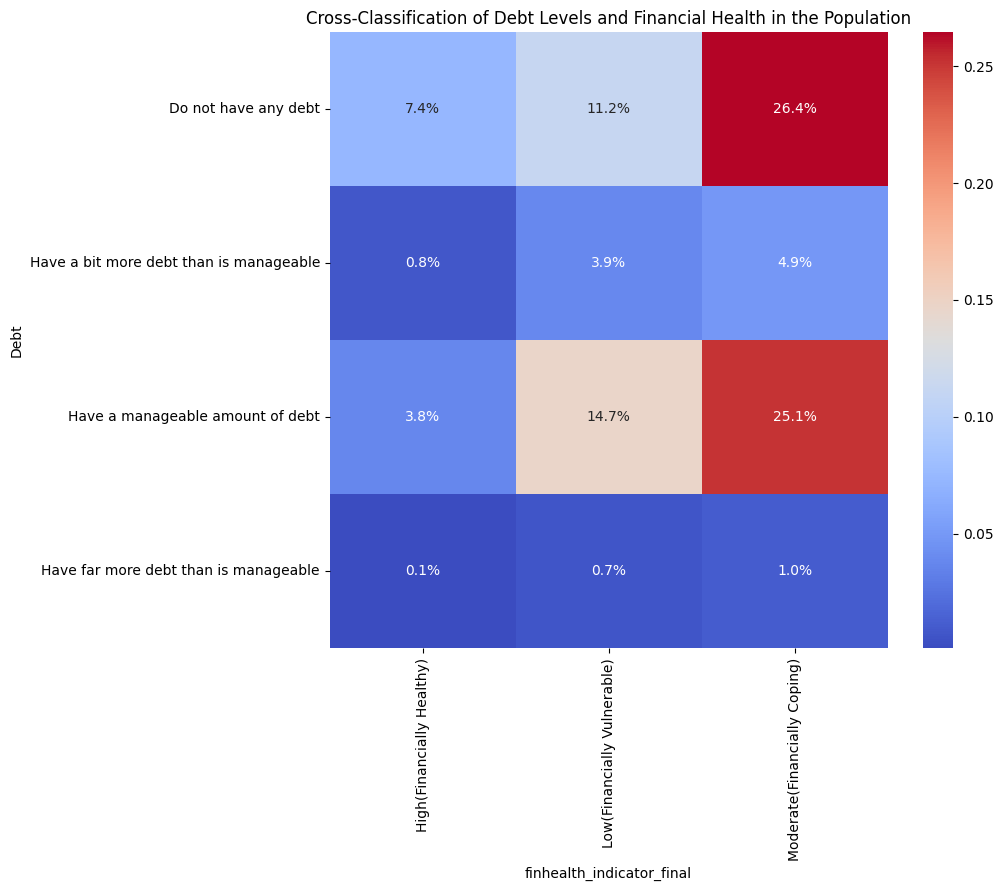

In [ ]:
ct = pd.crosstab(index = debt, columns = fin_indicator)
ct_pct = ct/ct.values.sum()

fig = plt.figure(figsize = (9,8))
sns.heatmap(ct_pct, annot = True, cmap = "coolwarm", fmt = ".1%")
plt.title("Cross-Classification of Debt Levels and Financial Health in the Population");

97.8% of Nigeria youths don't have insurance

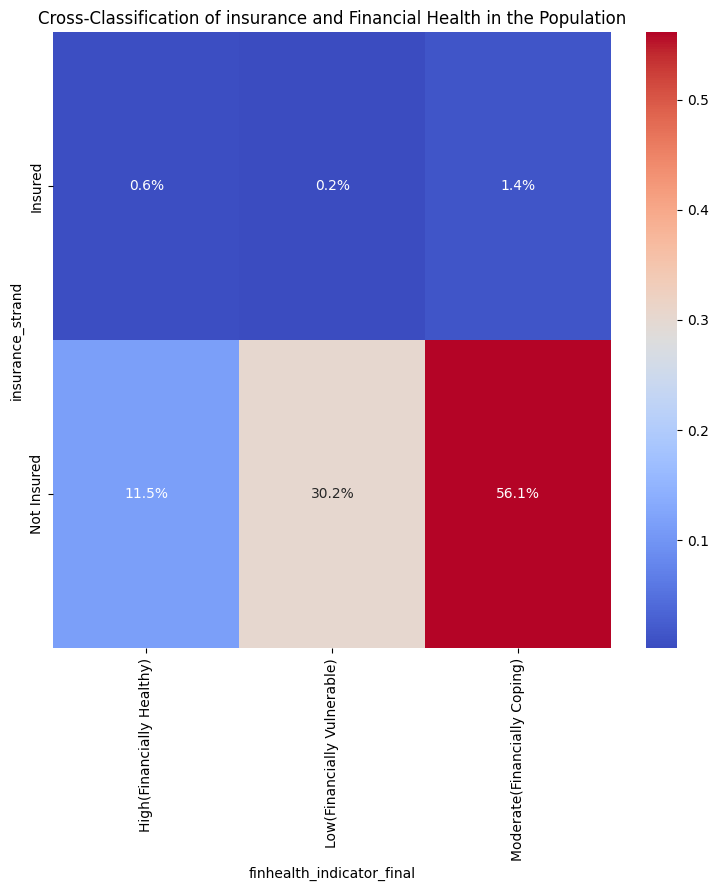

In [ ]:
ct = pd.crosstab(index = df["insurance_strand"], columns = fin_indicator)
ct_pct = ct/ct.values.sum()

fig = plt.figure(figsize = (9,8))
sns.heatmap(ct_pct, annot = True, cmap = "coolwarm", fmt = ".1%")
plt.title("Cross-Classification of insurance and Financial Health in the Population");

In [ ]:
tax_certi = df["Tax_cert"].replace({1: "Yes", 2: "No"})
tax_invoice = df["Tax_invoice"].replace({1: "Yes", 2: "No"})
voters_card = df["Voters_card"].replace({1: "Yes", 2: "No"})

tax_invoice_count = tax_certi.value_counts(normalize=True).sort_values()
print(f"Youths that have Local Govt rates and  tax invoice: {tax_invoice_count.iloc[0]: .1%}")
print(f"Youths that don't have Local Govt rates and  tax invoice: {tax_invoice_count.iloc[1]: .1%}")

tax_certi_count = tax_certi.value_counts(normalize=True).sort_values()
print(f"\nThe percentage of youths that have tax clearance certificate: {tax_certi_count.iloc[0]: .1%}")
print(f"The percentage of youths that don't have tax clearance certificate: {tax_certi_count.iloc[1]: .1%}")

Youths that have Local Govt rates and  tax invoice:  1.9%
Youths that don't have Local Govt rates and  tax invoice:  98.1%

The percentage of youths that have tax clearance certificate:  1.9%
The percentage of youths that don't have tax clearance certificate:  98.1%


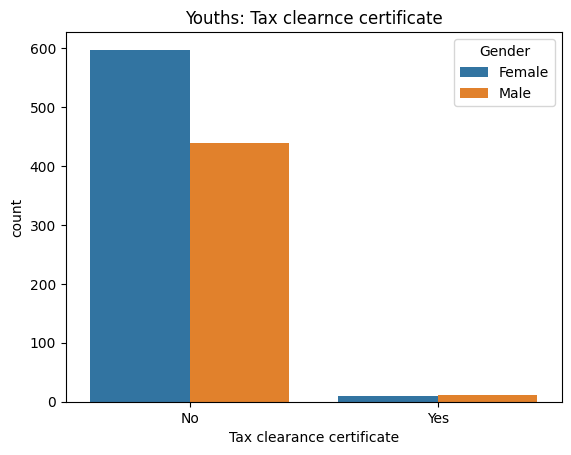

In [ ]:
sns.countplot(x=tax_certi, hue = gender)
plt.title("Youths: Tax clearnce certificate")
plt.xlabel("Tax clearance certificate");

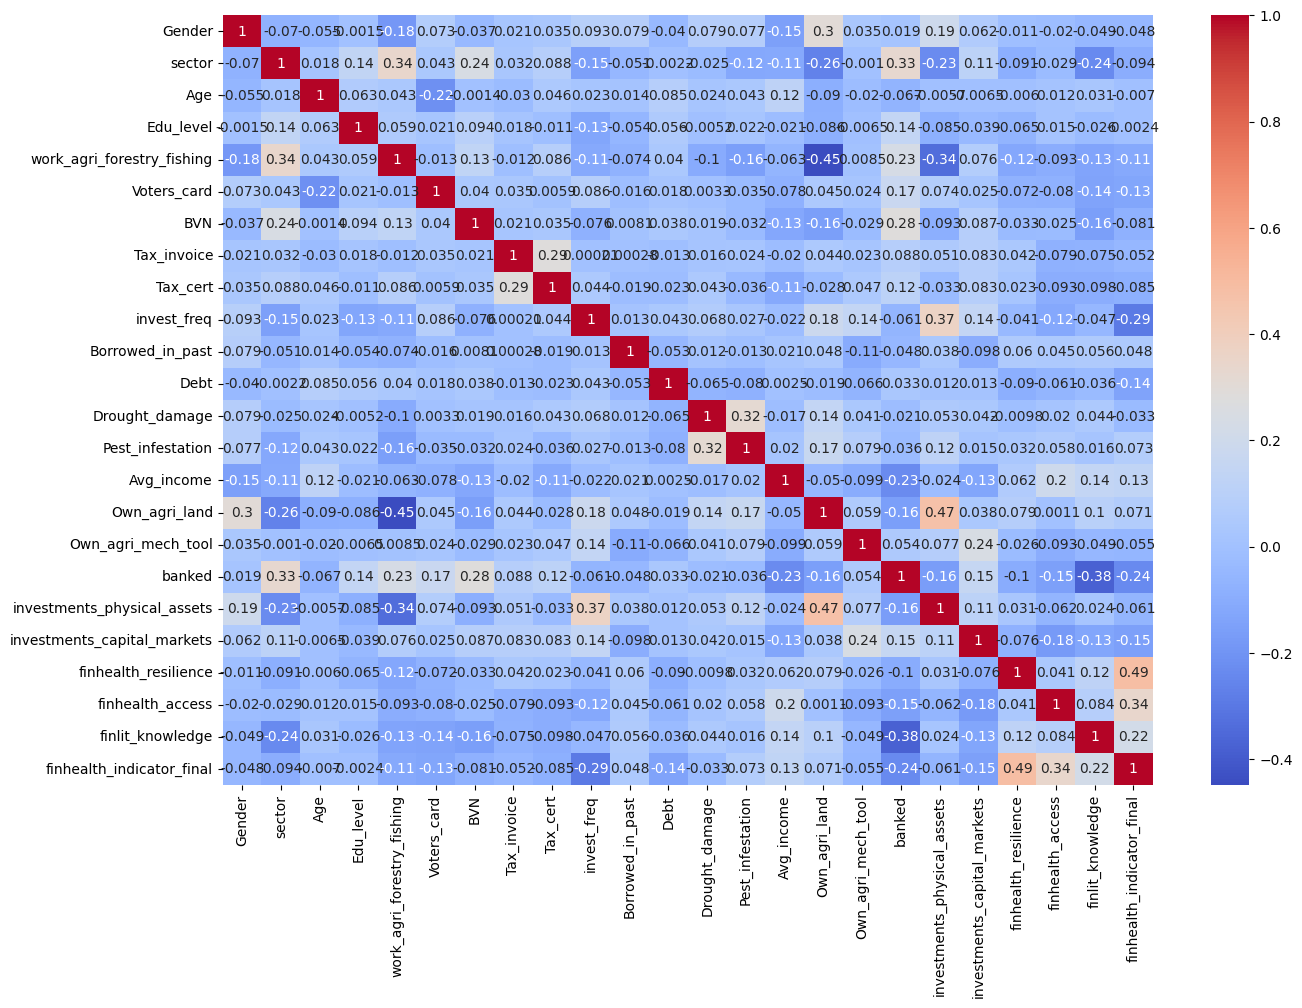

In [ ]:
#check for correlation
numeric_df = df.select_dtypes(include=['number'])
correlation = numeric_df.corr()

fig = plt.figure(figsize=(15,10))
sns.heatmap(correlation, cmap = "coolwarm", annot = True);

## Machine learning model

## Clustering using Kmeans

In [ ]:
# Encode categorical features
import joblib
cols = ["insurance_strand", "source_of_borrowing", "saving_strand"]
cat_encoders = {}
for col in cols:
  encoder = LabelEncoder()
  df[col] = encoder.fit_transform(df[col])
  cat_encoders[col] = encoder

joblib.dump(cat_encoders, 'label_encoders.pkl')

['label_encoders.pkl']

In [ ]:
#drop the gender and state column as we don't want access to finance to be biased by that
X = df.copy("deep")
X = X.drop(columns = ["state", "Gender"])

X.head()

,sector,Age,Edu_level,work_agri_forestry_fishing,Voters_card,BVN,Tax_invoice,Tax_cert,invest_freq,Borrowed_in_past,Debt,Drought_damage,Pest_infestation,Avg_income,Own_agri_land,Own_agri_mech_tool,banked,saving_strand,insurance_strand,investments_physical_assets,investments_capital_markets,finhealth_resilience,finhealth_access,finlit_knowledge,finhealth_indicator_final,source_of_borrowing
0,1,25,4,0,1,2,2,2,2,2,2,2,2,2,2,3,2,1,1,1,2,2,0,2,1,1
1,1,25,5,0,1,1,2,2,2,2,1,2,2,4,3,3,1,4,1,2,2,0,2,2,1,2
2,1,23,5,0,1,2,2,2,1,2,3,2,2,3,2,3,1,4,1,1,2,1,0,2,1,1
3,1,23,5,0,1,1,2,2,3,2,2,2,2,2,3,3,1,4,1,1,2,0,0,2,0,1
4,2,25,5,1,1,1,2,2,2,1,1,2,2,2,2,3,2,3,1,1,2,0,0,0,1,1


Factors that affects a farmers creditworthiness

In [ ]:
# High variance features: factors that impact a farmers "creditworthy."
X.var().sort_values(ascending = False)

,0
Edu_level,7.240911
Age,5.771996
Avg_income,3.235389
saving_strand,1.897233
finlit_knowledge,0.806421
Own_agri_land,0.744646
finhealth_resilience,0.577780
Debt,0.517068
invest_freq,0.411195
finhealth_indicator_final,0.391201


In [ ]:
vari = X.var().sort_values(ascending = False)
t_vari = X.apply(trimmed_var, limits = (0.1, 0.1))
fig = px.bar(vari, title = "Features that impacts a farmers creditworthiness")
fig.update_layout(xaxis_title = "Variance", yaxis_title = "Features")
fig.show()

silhouette score for k: [np.float64(0.3119280979065919), np.float64(0.2467459290453546), np.float64(0.2596967103176518), np.float64(0.25458079604503897), np.float64(0.19978230848736436), np.float64(0.16609463790785464), np.float64(0.16384685294784382), np.float64(0.16534654610869634), np.float64(0.15794490844119236), np.float64(0.14387239892398349), np.float64(0.1442324300585291), np.float64(0.13393163213313883), np.float64(0.13773394575254808), np.float64(0.12080269978313085), np.float64(0.12224542253485214), np.float64(0.1115620244139811), np.float64(0.11799787438450825), np.float64(0.11497695692297777)]


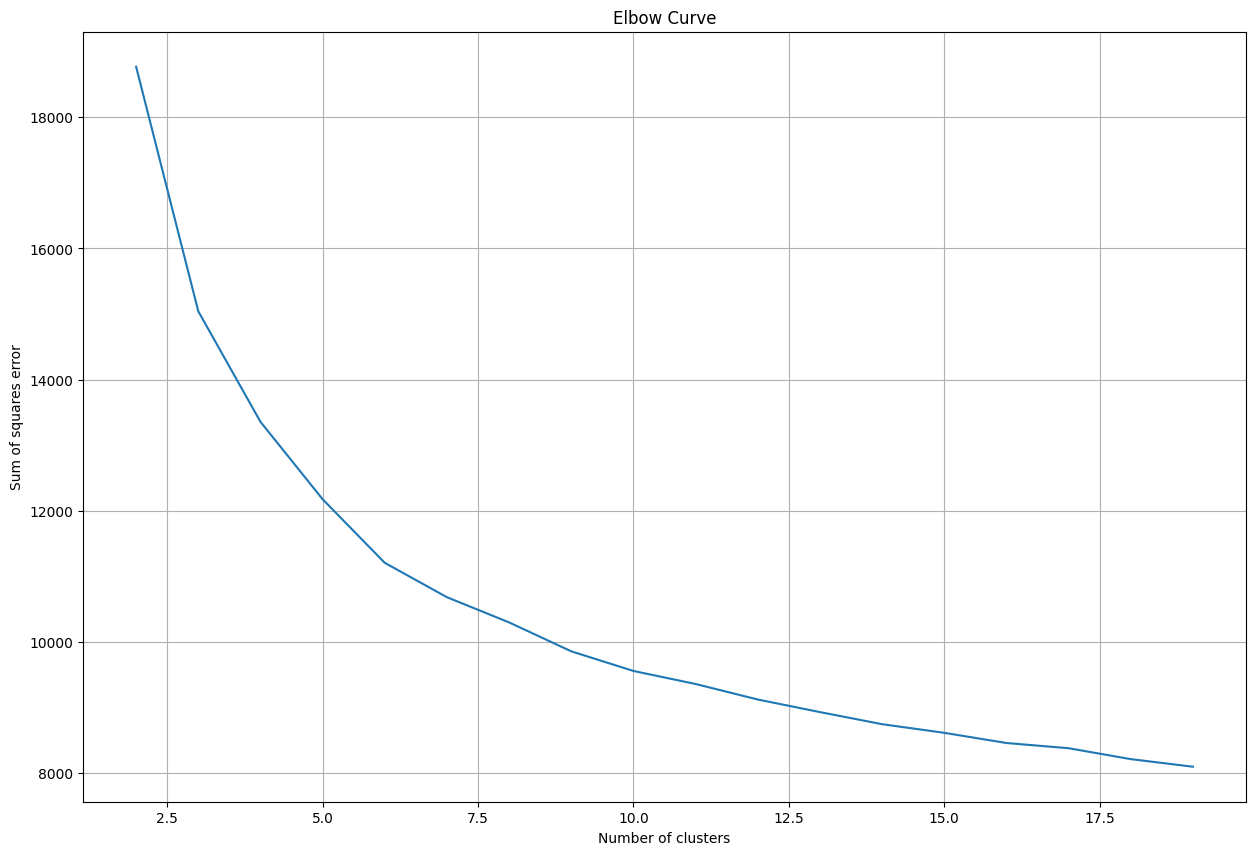

In [ ]:
from sklearn import metrics
n_clusters= range(2, 20)

inertia_errors = []
silhouette_score = []
for i in n_clusters:
    model = KMeans(n_clusters=i, random_state=42,n_init = 10, init = 'k-means++' )
    model.fit(X)

    inertia_errors.append(model.inertia_)
    score = metrics.silhouette_score(X, model.labels_, random_state = 42)
    silhouette_score.append(score)

print(f"silhouette score for k: {silhouette_score}")
fig = plt.figure(figsize = (15,10))

plt.plot(n_clusters, inertia_errors)
plt.xlabel("Number of clusters")
plt.ylabel("Sum of squares error")
plt.title("Elbow Curve")
plt.grid(True)
plt.show();

considering the silhoutte score of 0.31 for two clusters and the task at hand, which is a classification task, Two clusters will be used.

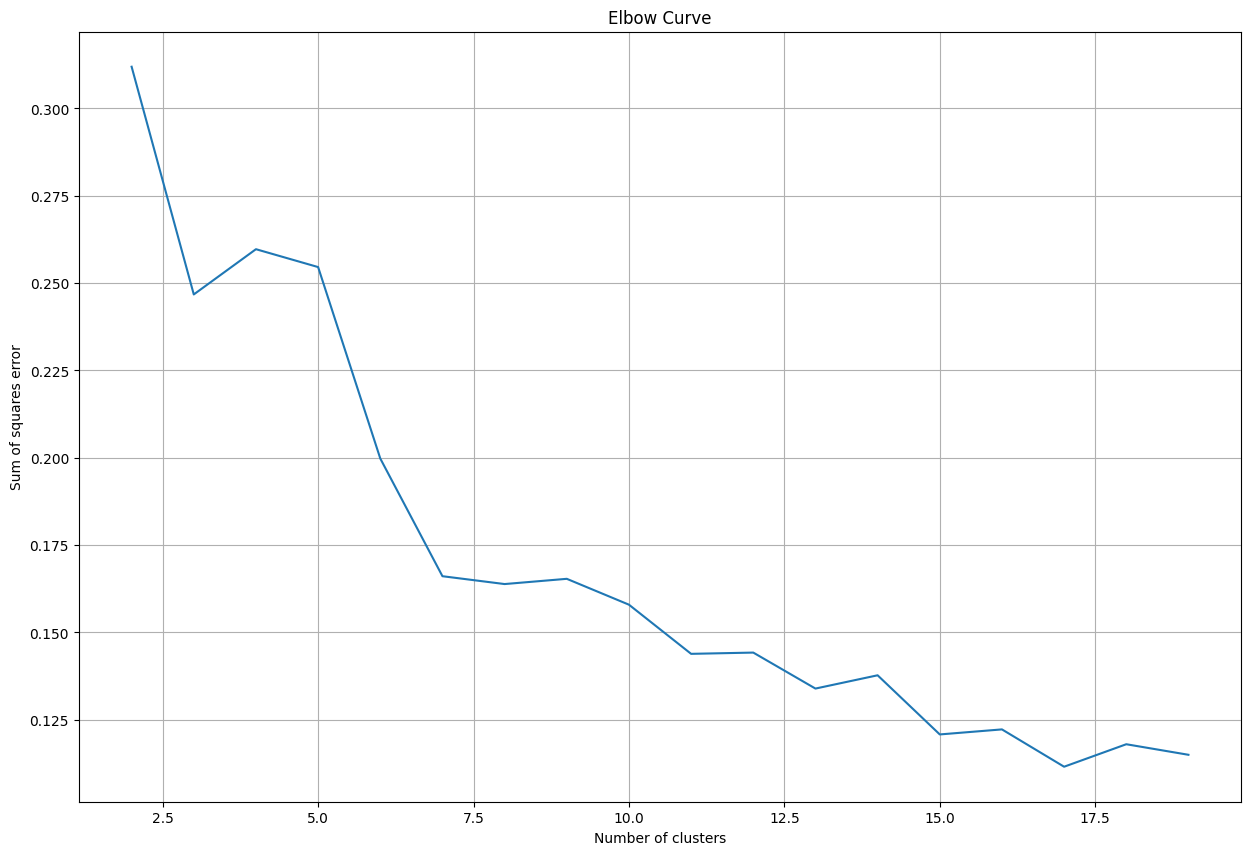

In [ ]:
# silhouette score
fig = plt.figure(figsize=(15,10))
plt.plot(n_clusters, silhouette_score)
plt.xlabel("Number of clusters")
plt.ylabel("Sum of squares error")
plt.title("Elbow Curve")
plt.grid(True)
plt.show();

In [ ]:
final_model = KMeans(n_clusters=2, verbose = 0, random_state=42, max_iter= 300, n_init = 10)
final_model.fit(X)

KMeans(n_clusters=2, n_init=10, random_state=42)

In [ ]:
labels = final_model.labels_
group = X.groupby(labels).mean()

fig = px.bar(group, barmode="group", title = "Mean financial info of young farmers" )
fig.update_layout(xaxis_title = "Cluster", yaxis_title ="Value" )
fig.show();

Visualize the clusters using PCA

In [ ]:
pca = PCA(n_components = 2, random_state=42)

# Transform `X`
X_t = pca.fit_transform(X)

# Put `X_t` into DataFrame
X_pca = pd.DataFrame(X_t, columns = ["PC1","PC2"])

print("X_pca shape:", X_pca.shape)
X_pca.head()

X_pca shape: (1055, 2)


,PC1,PC2
0,-1.023950,2.770123
1,-0.201159,3.153507
2,-0.563639,1.072984
3,-0.685585,0.841206
4,-0.028274,2.549365


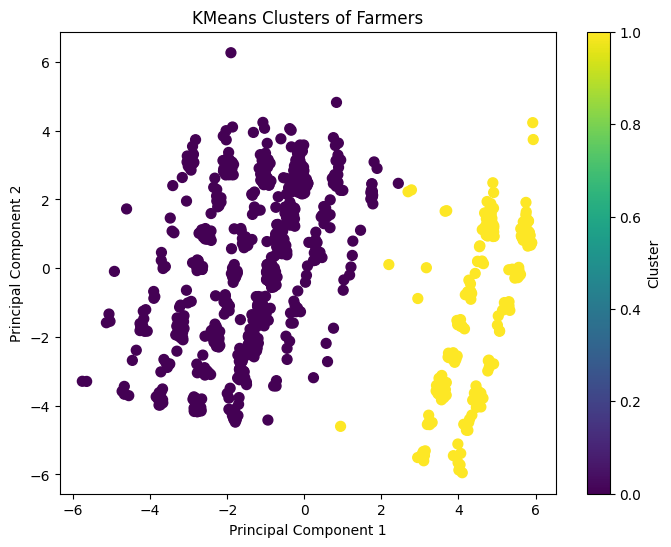

In [ ]:
plt.figure(figsize=(8,6))
plt.scatter(X_pca.iloc[:, 0], X_pca.iloc[:, 1], c=final_model.labels_, cmap='viridis', s=50)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('KMeans Clusters of Farmers')
plt.colorbar(label='Cluster')
plt.show()


In [ ]:
loadings = pd.DataFrame(pca.components_.T,
                        columns=['PC1', 'PC2'],
                        index=X.columns)
print(loadings.sort_values(by='PC1', ascending=False).head(15))

                                 PC1       PC2
Edu_level                   0.965364 -0.240899
Age                         0.248198  0.941513
sector                      0.027619 -0.010780
banked                      0.025063 -0.033864
Debt                        0.020790  0.021143
BVN                         0.018267 -0.011535
work_agri_forestry_fishing  0.015070  0.001732
Avg_income                  0.004358  0.213334
Pest_infestation            0.003225  0.005878
finhealth_access            0.002670  0.009624
insurance_strand            0.001313 -0.001159
Tax_invoice                 0.000579 -0.002384
Tax_cert                    0.000100  0.001275
Drought_damage             -0.000332  0.002378
Own_agri_mech_tool         -0.001413 -0.004228


## Key Observations

1. Cluster 0 farmers have lower Income level and education comapared with cluster 1 farmers.

2. clutser 0 farmers experiences drought and pest infestation more than cluster 1 farmers.

3. Cluster 1 farmers have slightly more debt than those in Cluster 0.

However considering that higher number is imputed for low education level and other features such as "not saving/Invest, cluster 0  farmers might be considered creditworthy than cluster 1 farmers

In [ ]:
# Get average feature values per cluster
pd.set_option('display.max_columns', None)
cluster_profiles = X.groupby(final_model.labels_).mean()
cluster_profiles


,sector,Age,Edu_level,work_agri_forestry_fishing,Voters_card,BVN,Tax_invoice,Tax_cert,invest_freq,Borrowed_in_past,Debt,Drought_damage,Pest_infestation,Avg_income,Own_agri_land,Own_agri_mech_tool,banked,saving_strand,insurance_strand,investments_physical_assets,investments_capital_markets,finhealth_resilience,finhealth_access,finlit_knowledge,finhealth_indicator_final,source_of_borrowing
0,1.497567,22.419708,4.430657,0.424574,1.350365,1.531630,1.976886,1.979319,2.457421,1.164234,1.655718,1.935523,1.862530,2.222628,2.441606,2.950122,1.436740,2.538929,0.974453,1.473236,1.939173,0.566910,0.233577,1.041363,0.840633,1.237226
1,1.793991,22.502146,10.386266,0.579399,1.442060,1.729614,1.995708,1.987124,2.201717,1.103004,1.772532,1.909871,1.849785,1.866953,2.133047,2.948498,1.798283,2.081545,0.991416,1.291845,1.948498,0.386266,0.193133,0.712446,0.729614,1.107296


In [ ]:
#add  cluster column to the data
cluster_labels = final_model.labels_

df_work = X.copy("deep")
df_work["cluster"] = cluster_labels

df_work.head()

,sector,Age,Edu_level,work_agri_forestry_fishing,Voters_card,BVN,Tax_invoice,Tax_cert,invest_freq,Borrowed_in_past,Debt,Drought_damage,Pest_infestation,Avg_income,Own_agri_land,Own_agri_mech_tool,banked,saving_strand,insurance_strand,investments_physical_assets,investments_capital_markets,finhealth_resilience,finhealth_access,finlit_knowledge,finhealth_indicator_final,source_of_borrowing,cluster
0,1,25,4,0,1,2,2,2,2,2,2,2,2,2,2,3,2,1,1,1,2,2,0,2,1,1,0
1,1,25,5,0,1,1,2,2,2,2,1,2,2,4,3,3,1,4,1,2,2,0,2,2,1,2,0
2,1,23,5,0,1,2,2,2,1,2,3,2,2,3,2,3,1,4,1,1,2,1,0,2,1,1,0
3,1,23,5,0,1,1,2,2,3,2,2,2,2,2,3,3,1,4,1,1,2,0,0,2,0,1,0
4,2,25,5,1,1,1,2,2,2,1,1,2,2,2,2,3,2,3,1,1,2,0,0,0,1,1,0


## Classification using tree model
RANDOM FOREST CLASSIFIER

In [ ]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import precision_score, recall_score

In [ ]:
# split data into feature matrix and target vectot
target = "cluster"
X = df_work.drop(columns = target, axis = 1)
y = df_work[target]

X_train,X_test,y_train,y_test = train_test_split(X,y, test_size = 0.2, random_state = 42)

Set a minimum performance benchmark for the model

In [ ]:
#baseline model
acc_baseline = y_train.value_counts(normalize=True).max()
print("Baseline Accuracy:", round(acc_baseline, 4))

Baseline Accuracy: 0.7749


In [ ]:
clf = RandomForestClassifier(random_state = 42)

params = {
    "n_estimators": range(25,100,25),
    "max_depth": range(10,50,10),
    "min_samples_split": range(2,10,2)
}

model = GridSearchCV(
    clf,
    param_grid = params,
    n_jobs = -1,
    cv = 5
)

model.fit(X_train, y_train)

best = model.best_params_
print(f"Best parameter:{best} ")
model_accuracy = model.score(X_test, y_test)
print(f"\nRandom forest classifier accuracy: {model_accuracy}")

Best parameter:{'max_depth': 10, 'min_samples_split': 4, 'n_estimators': 50} 

Random forest classifier accuracy: 1.0


Classification Report

In [ ]:
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       168
           1       1.00      1.00      1.00        43

    accuracy                           1.00       211
   macro avg       1.00      1.00      1.00       211
weighted avg       1.00      1.00      1.00       211



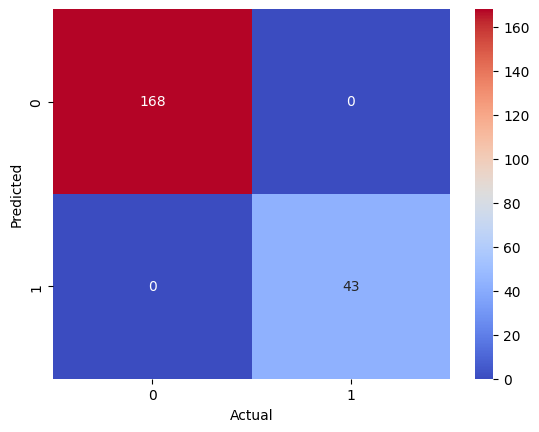

In [ ]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, cmap = "coolwarm", annot = True, fmt = "g")
plt.xlabel("Actual")
plt.ylabel("Predicted");

This high accuracy, precision and recall points to the fact that something might be wrong probably from the clustering

In [ ]:
import joblib
joblib.dump(model, "model_RF.pkl")

['model_RF.pkl']

GRADIENT BOOSTING CLASSIFIER

In [ ]:
clf2 = GradientBoostingClassifier()

params = {
    'n_estimators': [50, 100],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': range(10,50,10),
    "min_samples_split": range(2,10,2)
}

model2 = GridSearchCV(
    clf2,
    param_grid = params,
    n_jobs = -1,
    cv = 5
)

model2.fit(X_train,y_train)

model2_accuracy = model2.score(X_test,y_test)
print(f"Gradient Boosting Classifier accuracy: {model2_accuracy}")

Gradient Boosting Classifier accuracy: 1.0


In [ ]:
y_pred2 = model2.predict(X_test)
print(classification_report(y_test, y_pred2))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       168
           1       1.00      1.00      1.00        43

    accuracy                           1.00       211
   macro avg       1.00      1.00      1.00       211
weighted avg       1.00      1.00      1.00       211



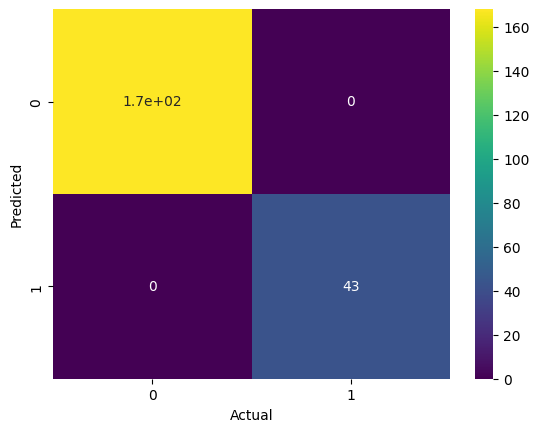

In [ ]:
cm2 = confusion_matrix(y_test, y_pred2)
sns.heatmap(cm2, annot = True, cmap = "viridis")
plt.xlabel("Actual")
plt.ylabel("Predicted");

In [ ]:
import joblib
joblib.dump(model2, "model_GB.pkl")

['model_GB.pkl']

In [ ]:
cluster_labels = final_model.labels_

df_work = X.copy("deep")
df_work["cluster"] = cluster_labels

df_work.head()

In [ ]:
mask = df_work["cluster"] == 1
df_work = df_work[mask]

df_work.tail()

,sector,Age,Edu_level,work_agri_forestry_fishing,Voters_card,BVN,Tax_invoice,Tax_cert,invest_freq,Borrowed_in_past,Debt,Drought_damage,Pest_infestation,Avg_income,Own_agri_land,Own_agri_mech_tool,banked,saving_strand,credit_strand,insurance_strand,investments_physical_assets,investments_capital_markets,finhealth_resilience,finhealth_access,finlit_knowledge,finhealth_indicator_final,source_of_borrowing,cluster
